Imports

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import pandas as pd
import gym
import quantstats as qs
import matplotlib.pyplot as plt

sys.path.append(os.path.join(".."))
import gym_anytrading

from stable_baselines3.common.vec_env import DummyVecEnv

C:\Users\olith\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Create environment

In [2]:
TICKERS = ["NESZ", "CIMB", "MAY", "KLK"]
df = {}
directions_df = {}
dividends_df = {}
for ticker in TICKERS:
    df[ticker] = pd.read_csv(os.path.join("day_data", f"{ticker} MK Equity.csv"), parse_dates=True, index_col="Dates")
    d_df =  pd.read_csv(os.path.join("directions", f"Directions {ticker}.csv"), parse_dates=True, index_col="Dates")
    direction_start = d_df.index.get_loc(dt.datetime(2018, 1, 1)) + 1
    direction_end = d_df.index.get_loc(dt.datetime(2020, 1, 1))
    directions_df[ticker] = d_df.iloc[direction_start:direction_end]
    dividends_df[ticker] = pd.read_csv(os.path.join("dividends", f"{ticker} dividend.csv"), parse_dates=True, index_col="Date")

window_size = 30

val_start = df[TICKERS[0]].index.get_loc(dt.datetime(2018, 1, 1))
val_end = df[TICKERS[0]].index.get_loc(dt.datetime(2020, 1, 1))
print(val_start, val_end)

env_maker_val = lambda: gym.make(
    "daily-v0",
    df=df,
    window_size=window_size,
    frame_bound=(val_start, val_end),
    bankroll=100000.,
    dividends=dividends_df
)

env_val = DummyVecEnv([env_maker_val])

4695 5217
NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space


# Buy and hold baseline

In [3]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
while True:
    c += 1
    action = np.array([0, 1, 1, 1, 1])
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])
    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 10105.760000000002, 'total_profit': 10105.760000000002, 'position': array([ 124.09,  188.  , 5261.  , 3203.  , 1112.  ]), 'delta': array([ 16.09,   1.  ,  27.  , -18.  ,  -6.  ]), 'net_worth': 110105.75999999994}
Iterations: 521
Average cash: 0.09847599623790139


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          11.55%
CAGR﹪                     5.64%

Sharpe                     0.61
Smart Sharpe               0.55
Sortino                    0.85
Smart Sortino              0.77
Sortino/√2                 0.6
Smart Sortino/√2           0.55
Omega                      1.12

Max Drawdown               -12.55%
Longest DD Days            638
Volatility (ann.)          9.46%
Calmar                     0.45
Skew                       -0.35
Kurtosis                   3.26

Expected Daily %           0.02%
Expected Monthly %         0.46%
Expected Yearly %          5.62%
Kelly Criterion            5.63%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.96%
Expected Shortfall (cVaR)  -0.96%

Gain/Pain Ratio            0.12
Gain/Pain (1M)             0.55

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-02,2019-10-09,2019-12-31,638,-12.545126,-12.254620
2,2018-03-14,2018-03-20,2018-03-30,16,-5.299156,-4.875201
3,2018-02-05,2018-02-06,2018-02-19,14,-2.164326,-1.535031
4,2018-03-01,2018-03-01,2018-03-02,1,-0.483919,0.000000
5,2018-01-09,2018-01-10,2018-01-12,3,-0.347100,-0.344327


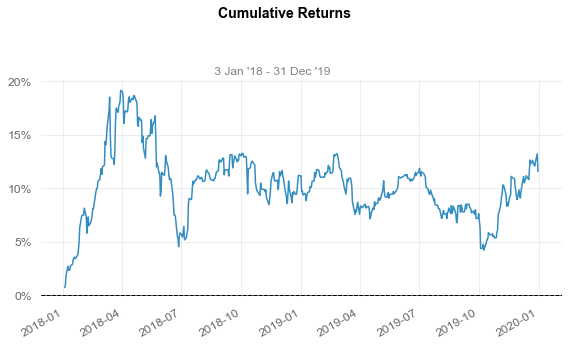

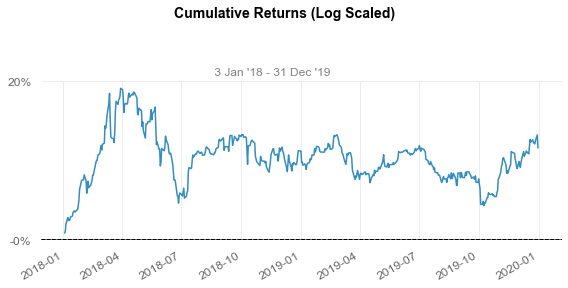

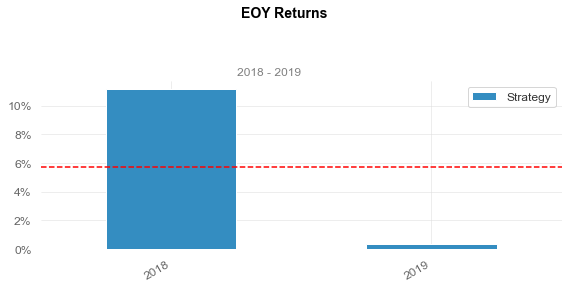

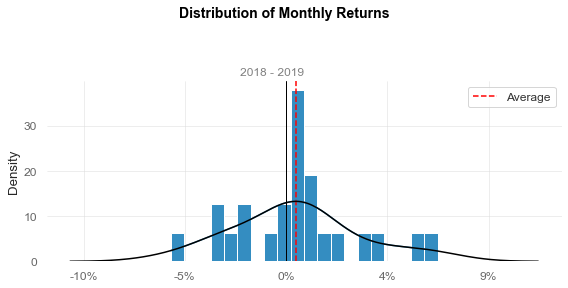

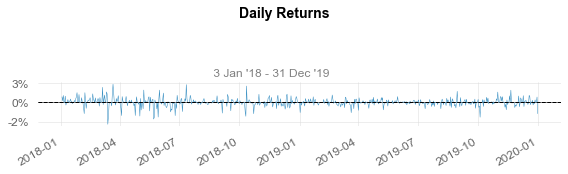

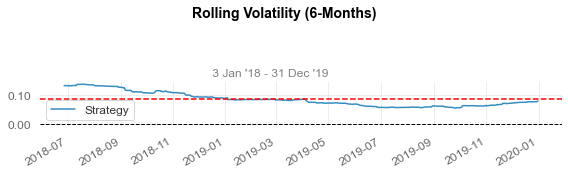

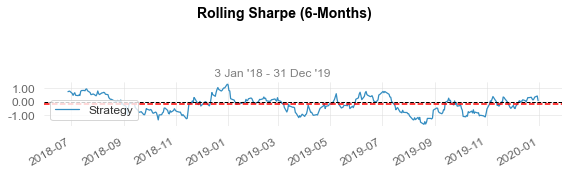

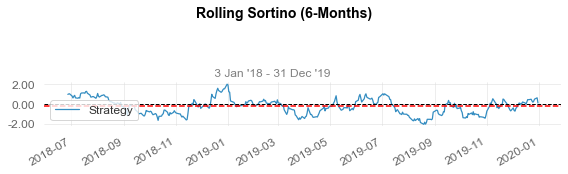

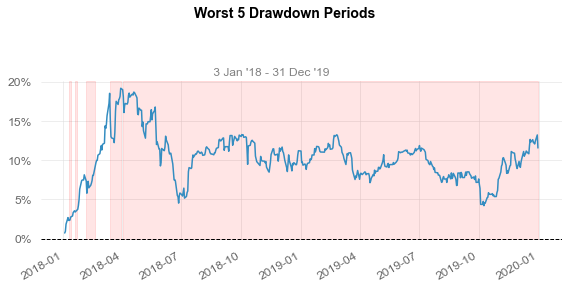

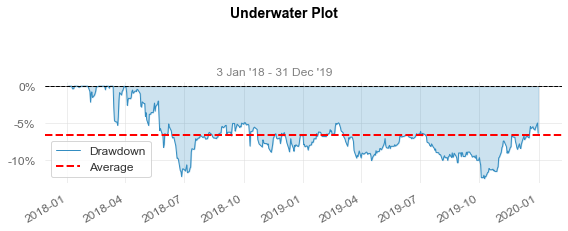

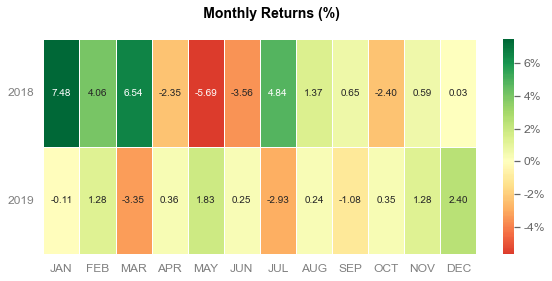

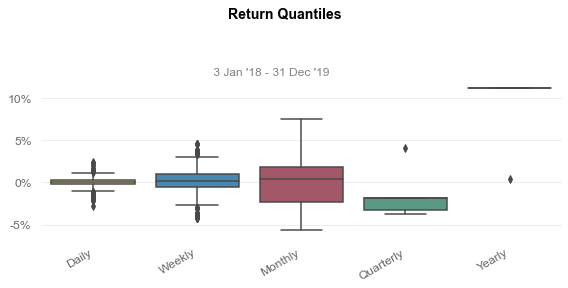

In [4]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Momentum baseline

In [5]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    c += 1
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i in range(len(TICKERS)):
        if observation[-1, i, 1] > 0:
            action[i + 1] = 1.

    if np.sum(action[1:]) == 0:
        action[0] = 1.
    else:
        action[0] = 0.
        stock_ts += 1

    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 1317.0600000001145, 'total_profit': 1317.0600000001145, 'position': array([  92.76,  348.  , 9722.  ,    0.  ,    0.  ]), 'delta': array([    90.9,    348. ,   9722. , -11841. ,      0. ]), 'net_worth': 101317.06000000026}
Iterations: 521
Average cash: 22.88796498374081
Time steps with stock: 77.15930902111324


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             69.0%

Cumulative Return          2.89%
CAGR﹪                     1.44%

Sharpe                     0.19
Smart Sharpe               0.17
Sortino                    0.26
Smart Sortino              0.23
Sortino/√2                 0.18
Smart Sortino/√2           0.17
Omega                      1.04

Max Drawdown               -18.0%
Longest DD Days            657
Volatility (ann.)          10.09%
Calmar                     0.08
Skew                       -1.07
Kurtosis                   12.55

Expected Daily %           0.01%
Expected Monthly %         0.12%
Expected Yearly %          1.43%
Kelly Criterion            1.95%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.04%
Expected Shortfall (cVaR)  -1.04%

Gain/Pain Ratio            0.04
Gain/Pain (1M)             0.1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-14,2019-10-09,2019-12-31,657,-18.003356,-17.672902
2,2018-02-06,2018-02-09,2018-02-15,9,-1.427664,-1.262925
3,2018-02-28,2018-03-01,2018-03-02,2,-1.164052,-0.685818
4,2018-01-09,2018-01-11,2018-01-15,6,-0.538388,-0.459208
5,2018-01-19,2018-01-19,2018-01-22,3,-0.370500,0.000000


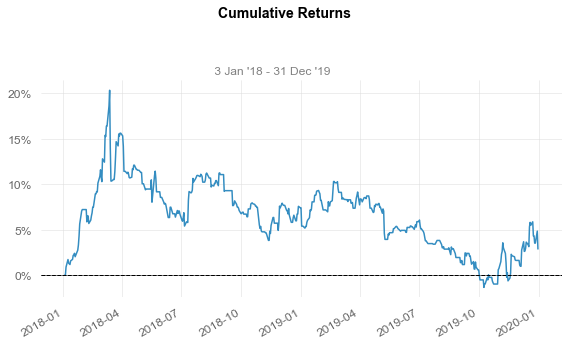

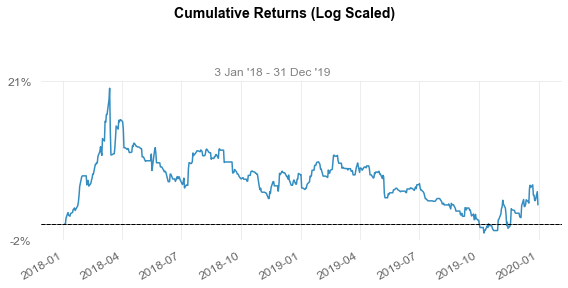

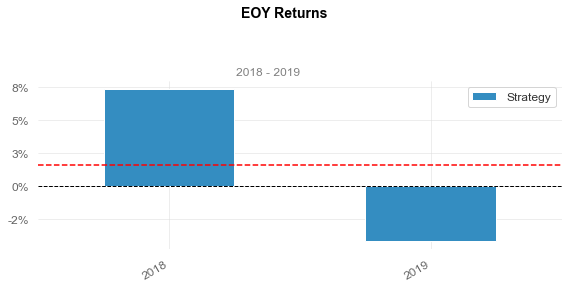

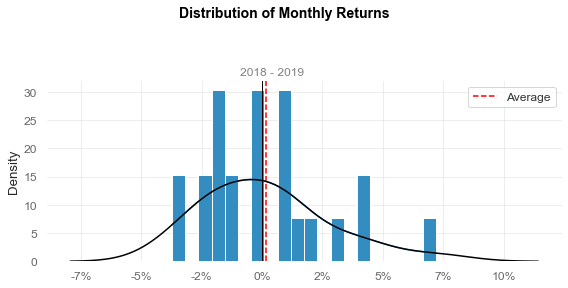

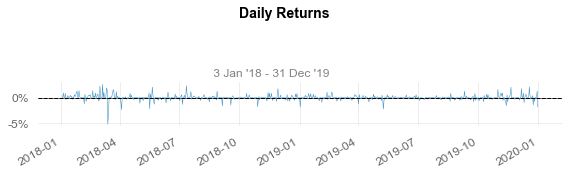

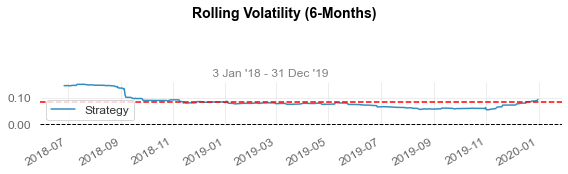

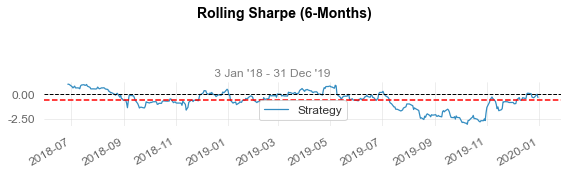

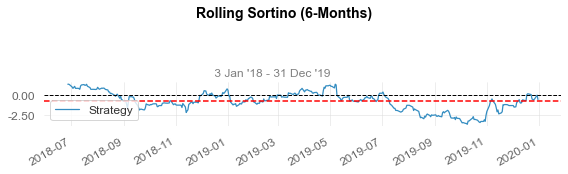

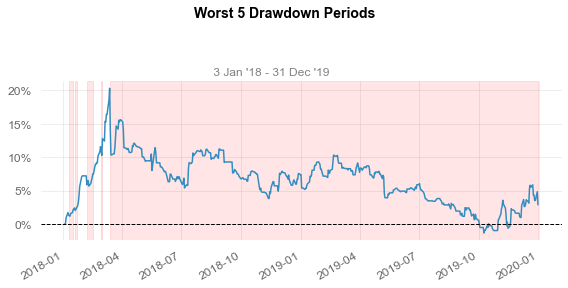

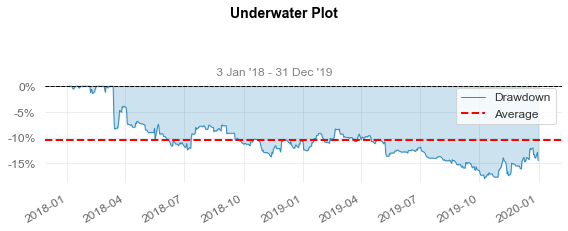

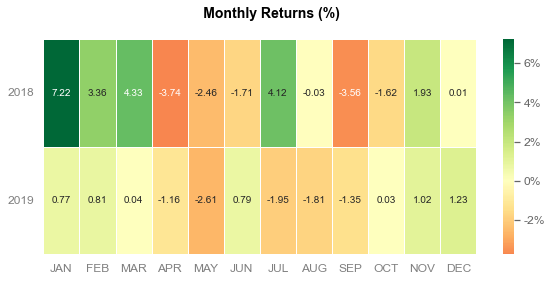

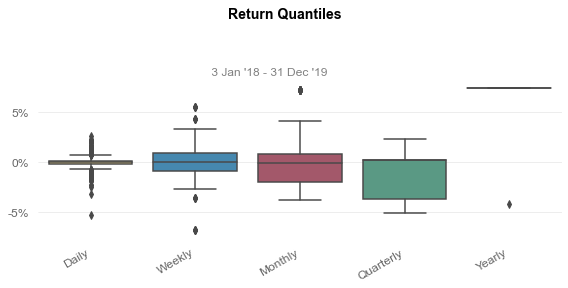

In [6]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Mean Reversion Baseline

In [7]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    c += 1
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i in range(len(TICKERS)):
        if observation[-1, i, 1] < 0:
            action[i + 1] = 1.

    if np.sum(action[1:]) == 0:
        action[0] = 1.
    else:
        action[1] = 0.
        stock_ts += 1

    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Stock TS:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': -7535.069999999998, 'total_profit': -7535.069999999998, 'position': array([8.2900e+00, 0.0000e+00, 0.0000e+00, 1.0701e+04, 0.0000e+00]), 'delta': array([ 5.2200e+00,  0.0000e+00, -1.7574e+04,  1.0701e+04,  0.0000e+00]), 'net_worth': 92464.9300000001}
Iterations: 521
Average cash: 32.64743438314247
Stock TS: 73.70441458733205


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             61.0%

Cumulative Return          -7.54%
CAGR﹪                     -3.86%

Sharpe                     -0.26
Smart Sharpe               -0.26
Sortino                    -0.34
Smart Sortino              -0.34
Sortino/√2                 -0.24
Smart Sortino/√2           -0.24
Omega                      0.94

Max Drawdown               -17.84%
Longest DD Days            587
Volatility (ann.)          11.75%
Calmar                     -0.22
Skew                       -1.41
Kurtosis                   17.96

Expected Daily %           -0.02%
Expected Monthly %         -0.33%
Expected Yearly %          -3.84%
Kelly Criterion            -3.62%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.23%
Expected Shortfall (cVaR)  -1.23%

Gain/Pain Ratio            -0.06
Gain/Pain (1M) 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-05-23,2018-06-27,2019-12-31,587,-17.838278,-14.805915
2,2018-04-13,2018-05-07,2018-05-22,39,-4.817084,-3.390114
3,2018-04-04,2018-04-04,2018-04-11,7,-1.011832,-0.698904
4,2018-03-05,2018-03-07,2018-03-12,7,-0.823119,-0.741450
5,2018-03-22,2018-03-26,2018-03-30,8,-0.653932,-0.515955


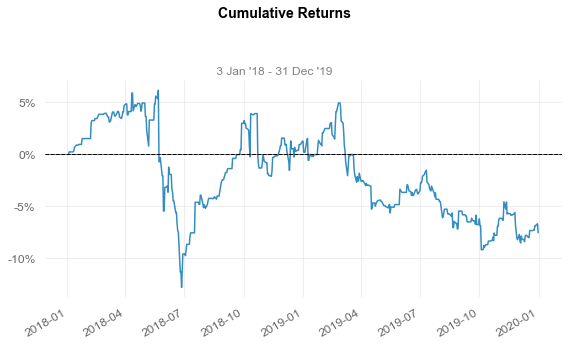

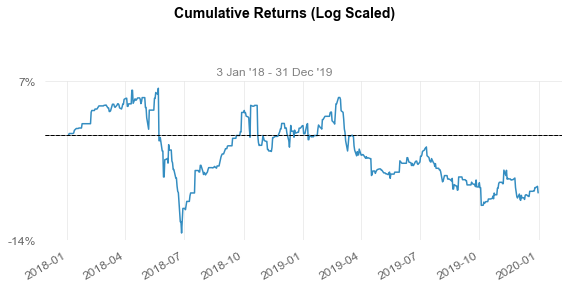

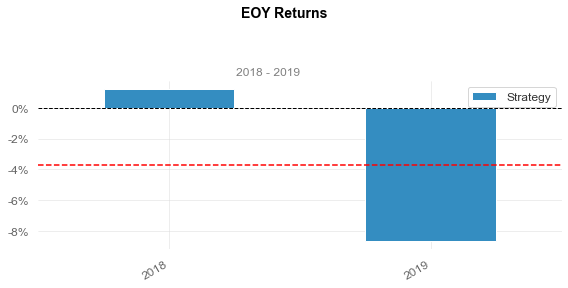

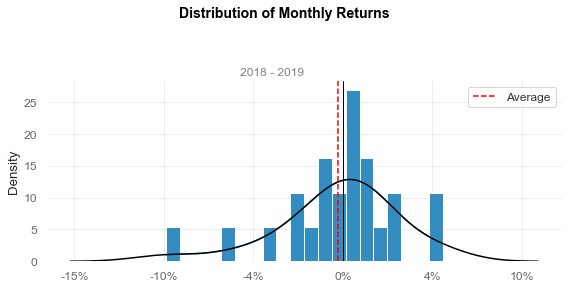

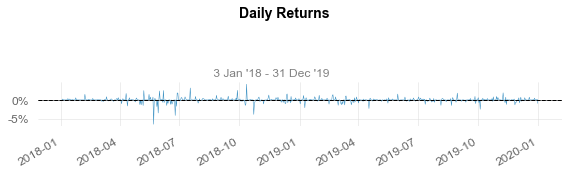

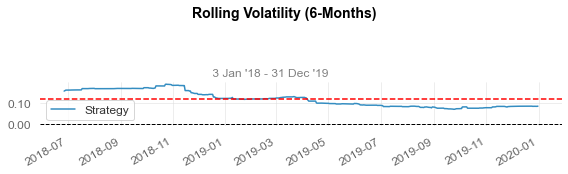

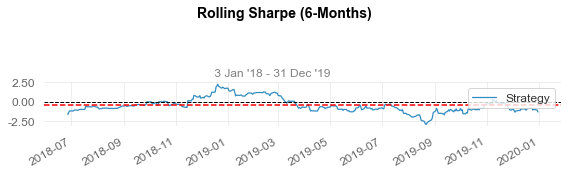

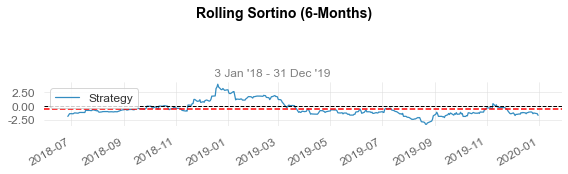

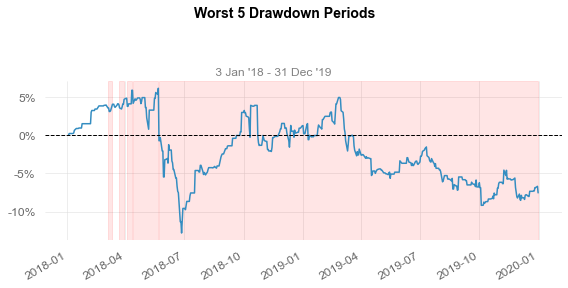

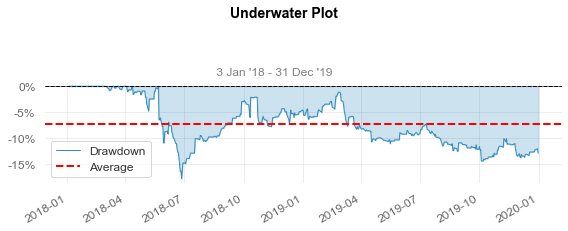

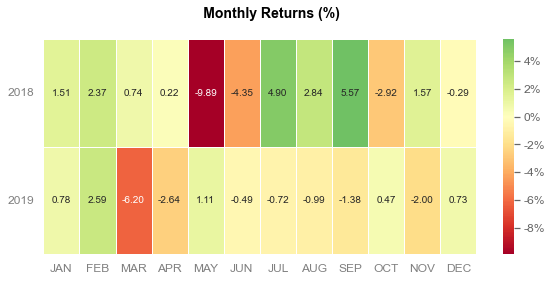

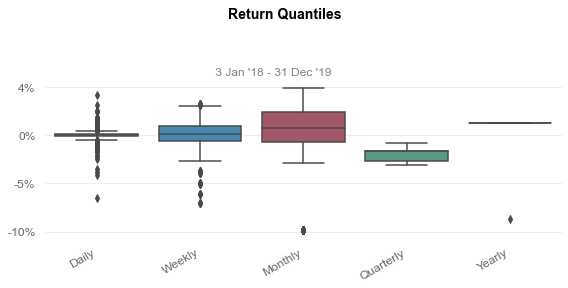

In [8]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# RSI 70 / 30 baseline

In [9]:
env = env_maker_val()
observation = env.reset()

c = 0
action = np.zeros(len(TICKERS) + 1, dtype=np.float)
cash_holding = []
stock_ts = 0
while True:
    for i, ticker in enumerate(TICKERS):
        if df[ticker].iloc[val_start + c].RSI_14D > 70.:
            action[i + 1] = 1.
        elif df[ticker].iloc[val_start + c].RSI_14D < 30:
            action[i + 1] = 0.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 10729.949999999997, 'total_profit': 10729.949999999997, 'position': array([ 122.81,  189.  , 5290.  , 3221.  , 1119.  ]), 'delta': array([ -0.29,   1.  ,  27.  , -19.  ,  -5.  ]), 'net_worth': 110729.95000000019}
Iterations: 521
Average cash: 5.085403240633452
Time steps with stock: 95.00959692898272


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             82.0%

Cumulative Return          12.68%
CAGR﹪                     6.18%

Sharpe                     0.64
Smart Sharpe               0.63
Sortino                    0.89
Smart Sortino              0.88
Sortino/√2                 0.63
Smart Sortino/√2           0.62
Omega                      1.13

Max Drawdown               -11.41%
Longest DD Days            638
Volatility (ann.)          9.79%
Calmar                     0.54
Skew                       -0.42
Kurtosis                   3.89

Expected Daily %           0.02%
Expected Monthly %         0.5%
Expected Yearly %          6.15%
Kelly Criterion            6.46%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.99%
Expected Shortfall (cVaR)  -0.99%

Gain/Pain Ratio            0.13
Gain/Pain (1M)             0.88

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-02,2019-01-08,2019-12-31,638,-11.407376,-10.605080
2,2018-03-14,2018-03-20,2018-03-30,16,-5.305626,-4.881001
3,2018-02-05,2018-02-06,2018-02-19,14,-2.540691,-1.992440
4,2018-01-09,2018-01-09,2018-01-15,6,-0.538621,-0.489775
5,2018-03-01,2018-03-01,2018-03-02,1,-0.485862,0.000000


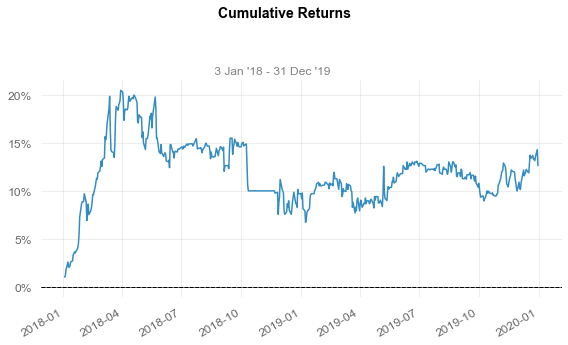

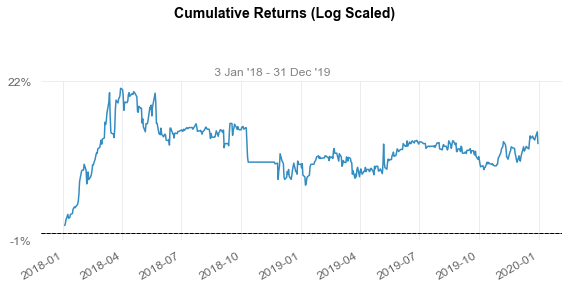

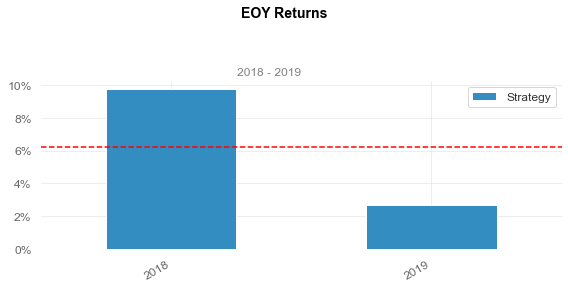

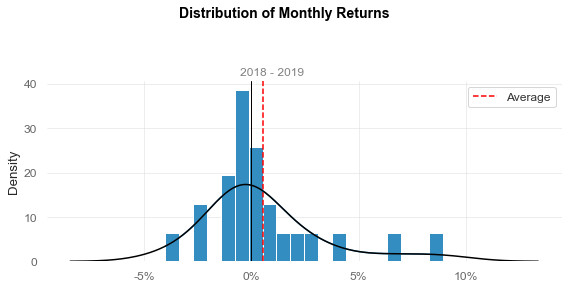

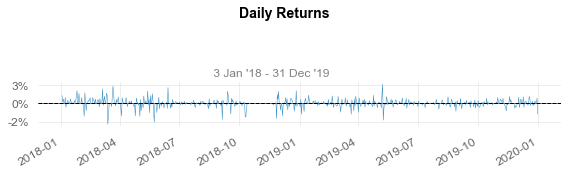

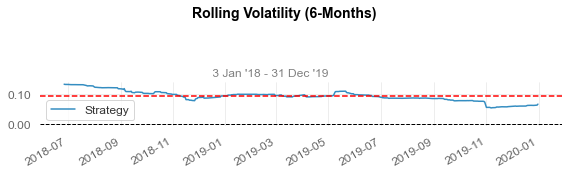

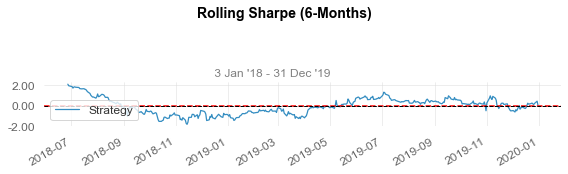

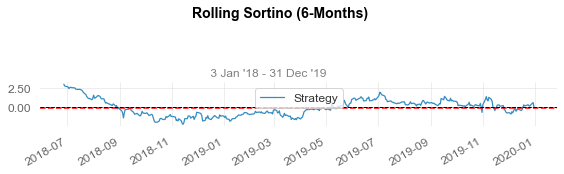

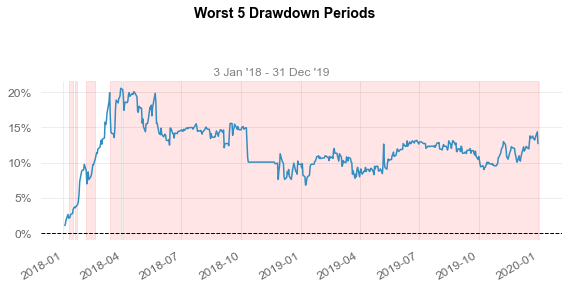

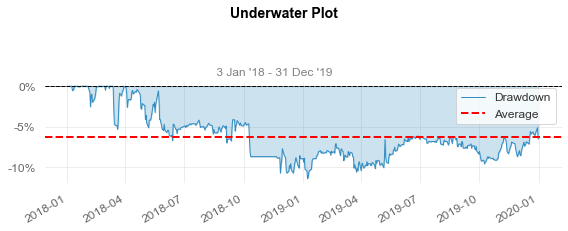

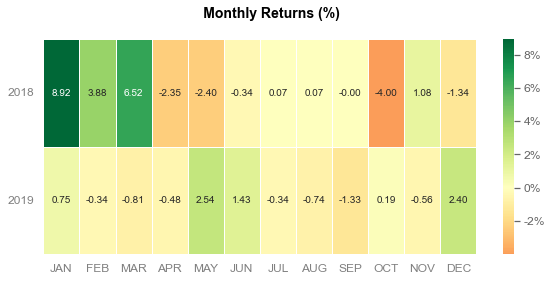

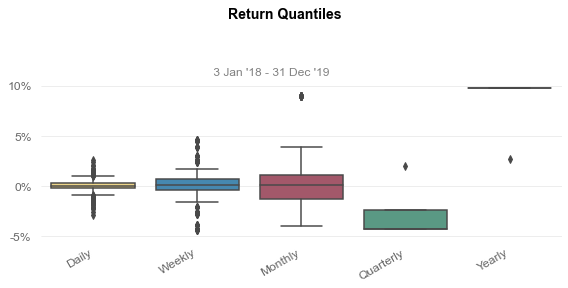

In [10]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Average Model Baseline

In [11]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        if directions_df[ticker].iloc[c].AVG == 1.:
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 10448.65000000008, 'total_profit': 10448.65000000008, 'position': array([  15.3,    0. , 7053. , 4295. , 1492. ]), 'delta': array([-20.27,   0.  ,  49.  , -16.  ,  -4.  ]), 'net_worth': 110448.65000000043}
Iterations: 521
Average cash: 5.25114850783946
Time steps with stock: 94.81765834932821


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             86.0%

Cumulative Return          11.85%
CAGR﹪                     5.78%

Sharpe                     0.56
Smart Sharpe               0.51
Sortino                    0.72
Smart Sortino              0.66
Sortino/√2                 0.51
Smart Sortino/√2           0.46
Omega                      1.12

Max Drawdown               -20.06%
Longest DD Days            656
Volatility (ann.)          10.73%
Calmar                     0.29
Skew                       -1.39
Kurtosis                   6.68

Expected Daily %           0.02%
Expected Monthly %         0.47%
Expected Yearly %          5.76%
Kelly Criterion            6.31%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.09%
Expected Shortfall (cVaR)  -1.09%

Gain/Pain Ratio            0.12
Gain/Pain (1M)             0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-14,2018-12-11,2019-12-30,656,-20.062708,-18.954057
2,2018-02-05,2018-02-09,2018-02-21,16,-2.697773,-2.464980
3,2019-12-31,2019-12-31,2019-12-31,0,-1.708382,NaN
4,2018-03-05,2018-03-08,2018-03-09,4,-0.897566,-0.672610
5,2018-01-09,2018-01-10,2018-01-12,3,-0.346969,-0.344007


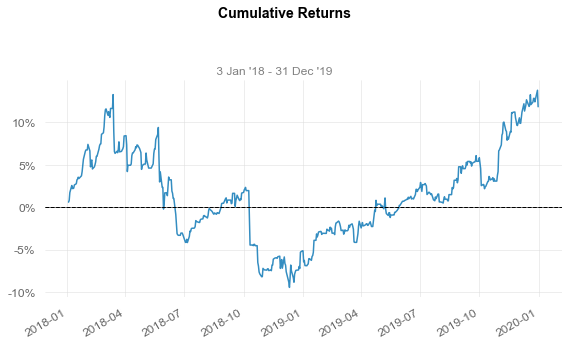

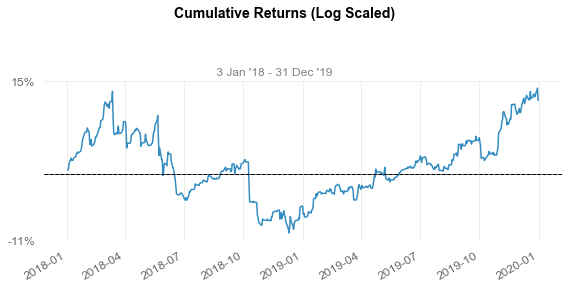

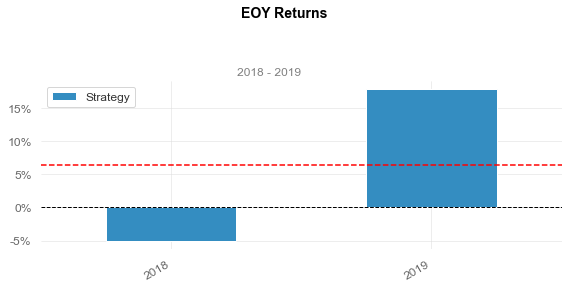

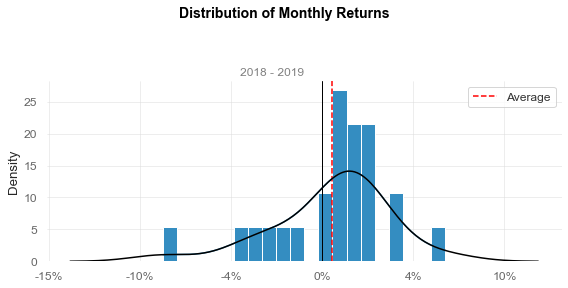

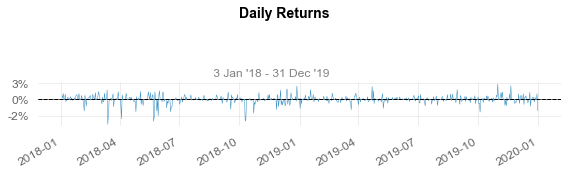

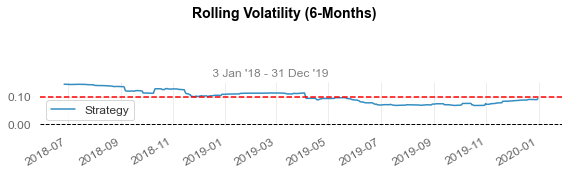

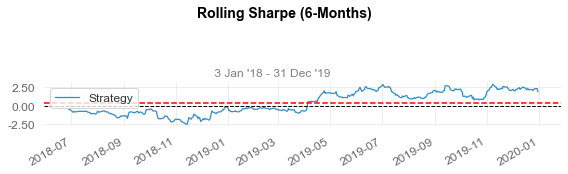

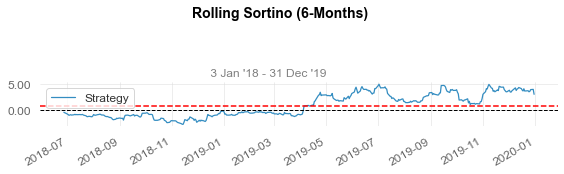

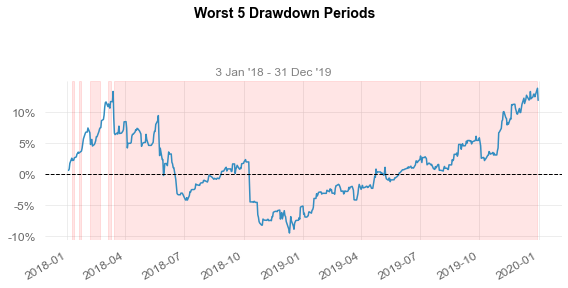

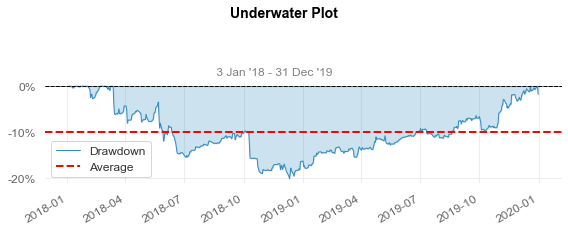

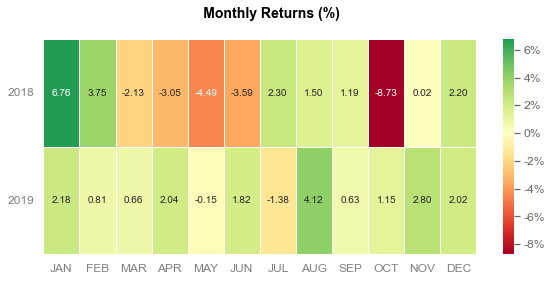

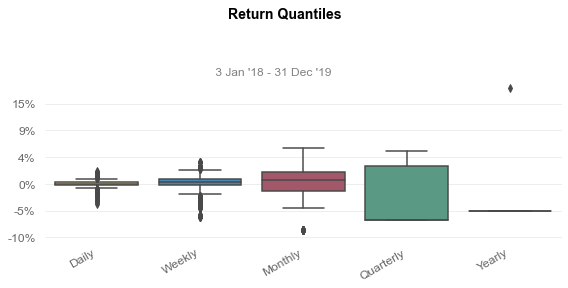

In [12]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Consensus Model baseline

In [13]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        if np.all([directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. for j in range(10)]):
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 44518.55000000009, 'total_profit': 44518.55000000009, 'position': array([144518.55,      0.  ,      0.  ,      0.  ,      0.  ]), 'delta': array([144492.78,      0.  ,      0.  ,  -8289.  ,  -2877.  ]), 'net_worth': 144518.55}
Iterations: 521
Average cash: 41.67476259991576
Time steps with stock: 58.34932821497121


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             49.0%

Cumulative Return          45.41%
CAGR﹪                     20.68%

Sharpe                     1.79
Smart Sharpe               1.77
Sortino                    2.53
Smart Sortino              2.5
Sortino/√2                 1.79
Smart Sortino/√2           1.77
Omega                      1.68

Max Drawdown               -8.9%
Longest DD Days            148
Volatility (ann.)          10.45%
Calmar                     2.32
Skew                       -2.17
Kurtosis                   30.51

Expected Daily %           0.07%
Expected Monthly %         1.57%
Expected Yearly %          20.59%
Kelly Criterion            25.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.01%
Expected Shortfall (cVaR)  -1.01%

Gain/Pain Ratio            0.68
Gain/Pain (1M)             5

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-09-18,2019-10-07,2019-11-07,50,-8.899871,-8.836648
2,2018-02-28,2018-04-04,2018-07-26,148,-5.101194,-4.235542
3,2019-02-27,2019-05-10,2019-07-01,124,-4.229270,-3.801749
4,2019-07-10,2019-08-28,2019-09-04,56,-2.635003,-2.406727
5,2018-02-05,2018-02-06,2018-02-13,8,-2.534930,-1.938590


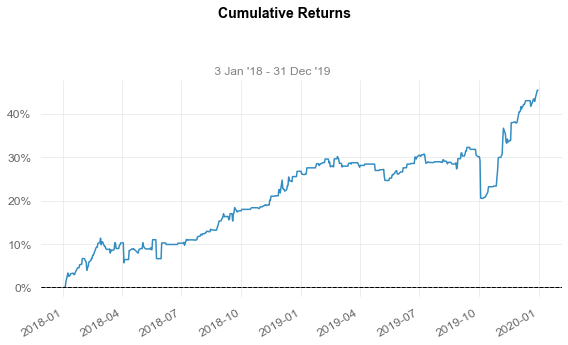

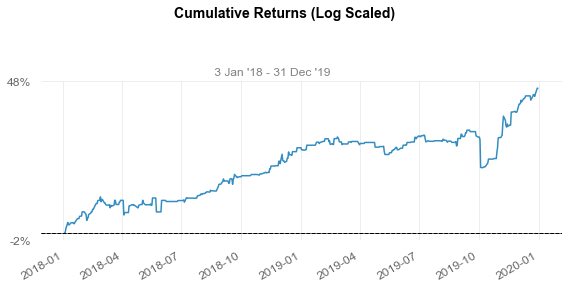

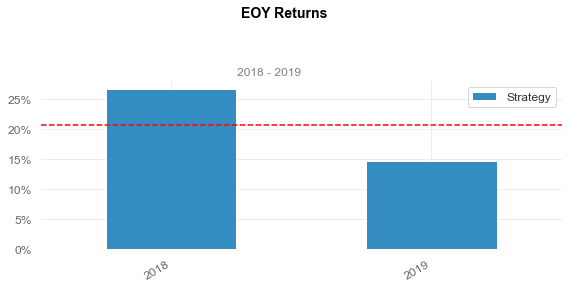

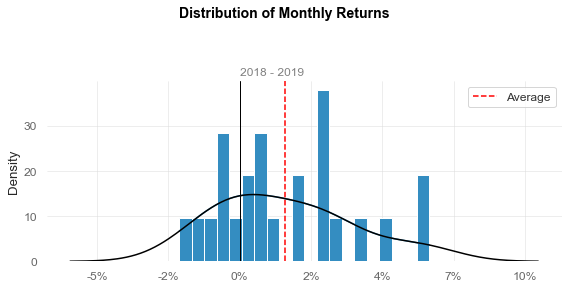

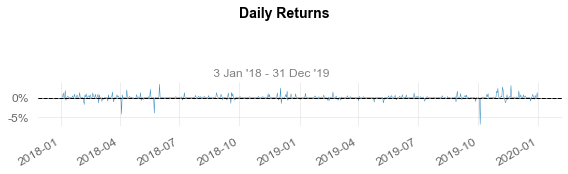

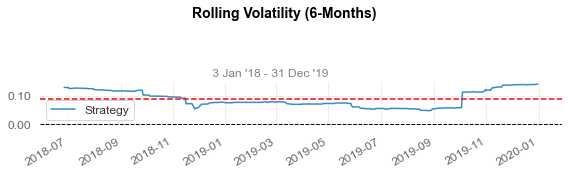

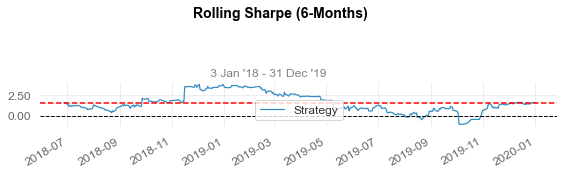

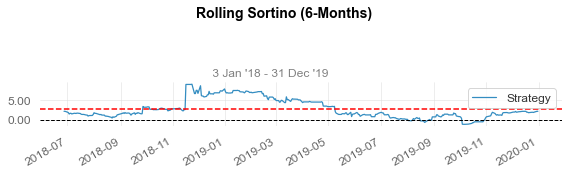

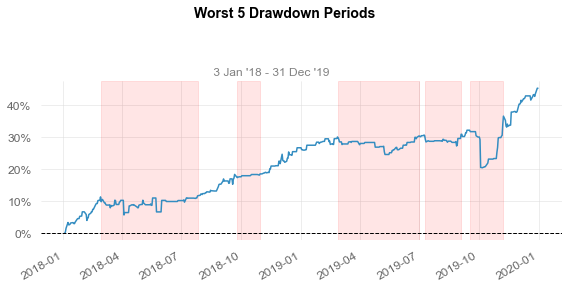

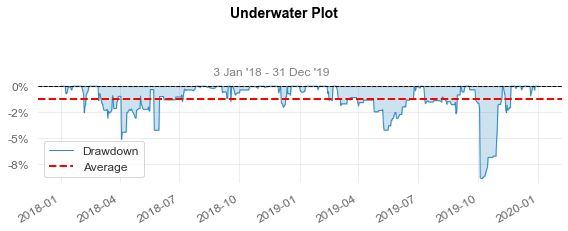

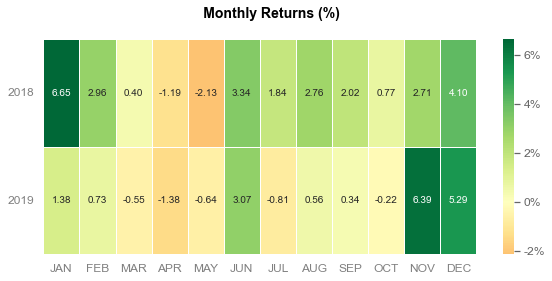

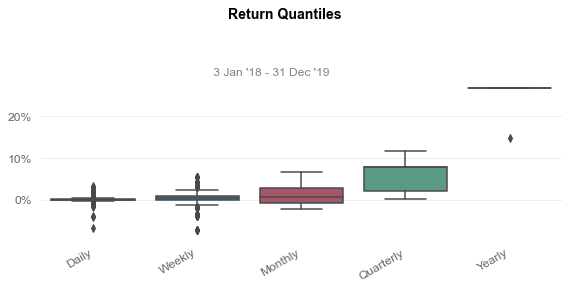

In [14]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Proportional baseline

In [15]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        action[i + 1] = np.sum([1 if directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. else 0. for j in range(10)])
        action[i + 1] = max(action[i + 1] - 4, 0.)

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 21625.28000000007, 'total_profit': 21625.28000000007, 'position': array([  22.01,    0.  , 8973.  , 3278.  , 1898.  ]), 'delta': array([-2.960e+00,  0.000e+00,  5.670e+03, -2.822e+03, -2.190e+02]), 'net_worth': 121625.28000000004}
Iterations: 521
Average cash: 3.5161101332229827
Time steps with stock: 96.54510556621881


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             88.0%

Cumulative Return          23.06%
CAGR﹪                     10.98%

Sharpe                     0.95
Smart Sharpe               0.87
Sortino                    1.28
Smart Sortino              1.18
Sortino/√2                 0.91
Smart Sortino/√2           0.83
Omega                      1.21

Max Drawdown               -14.84%
Longest DD Days            482
Volatility (ann.)          11.26%
Calmar                     0.74
Skew                       -1.07
Kurtosis                   8.33

Expected Daily %           0.04%
Expected Monthly %         0.87%
Expected Yearly %          10.93%
Kelly Criterion            10.28%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.12%
Expected Shortfall (cVaR)  -1.12%

Gain/Pain Ratio            0.21
Gain/Pain (1M)            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-05-23,2018-10-26,2019-09-17,482,-14.839551,-14.532264
2,2018-03-14,2018-05-07,2018-05-21,68,-5.671044,-5.648477
3,2019-09-27,2019-10-09,2019-10-31,34,-4.491857,-4.282570
4,2018-02-05,2018-02-06,2018-02-20,15,-2.531524,-2.498329
5,2019-11-11,2019-11-13,2019-11-20,9,-1.944871,-1.878290


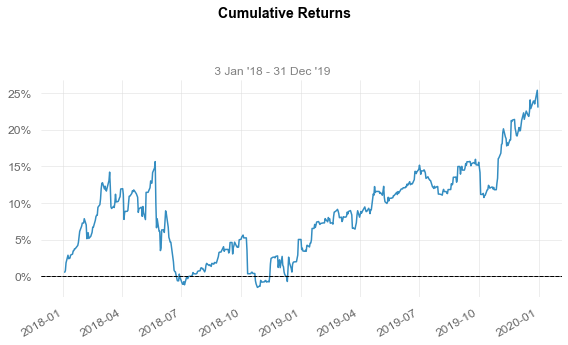

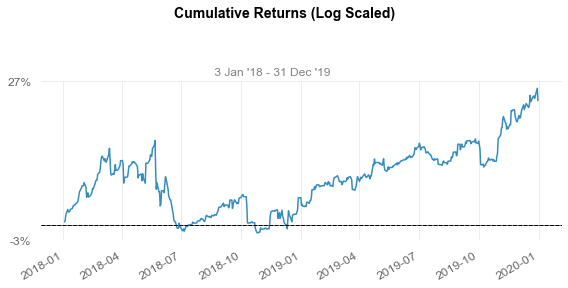

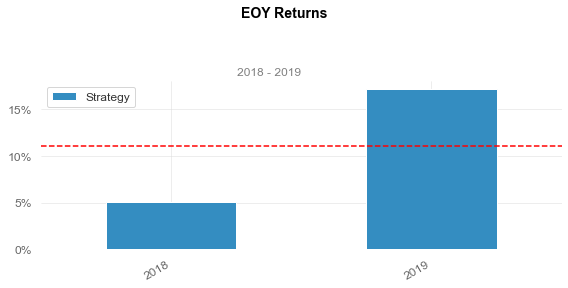

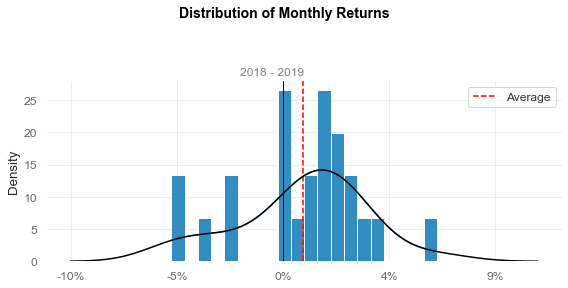

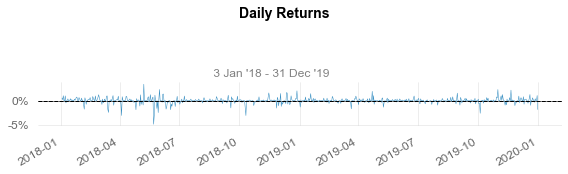

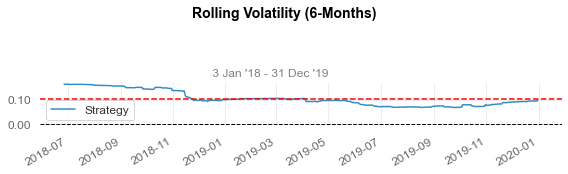

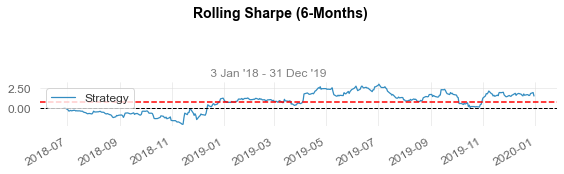

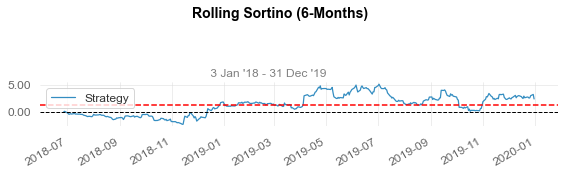

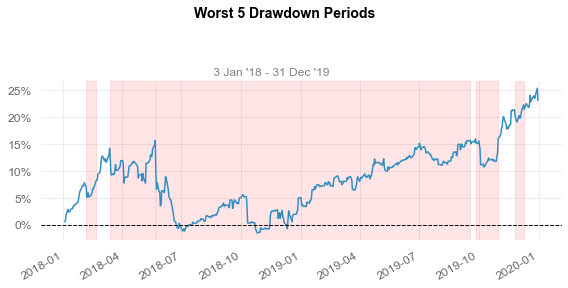

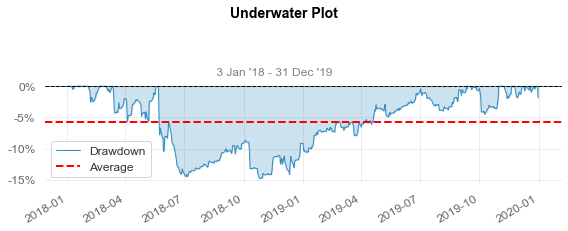

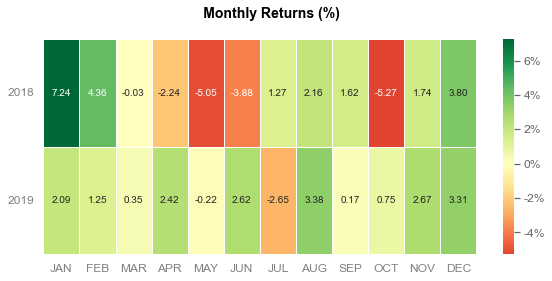

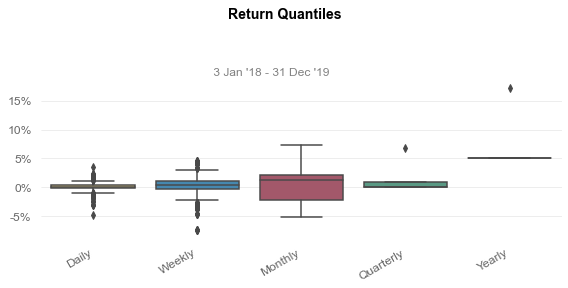

In [16]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Need 8 model

In [17]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        n_models = np.sum([1 if directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. else 0. for j in range(10)])
        if n_models >= 8:
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 31490.300000000145, 'total_profit': 31490.300000000145, 'position': array([   18.25,     0.  , 12647.  ,     0.  ,  2675.  ]), 'delta': array([-1.7900e+00,  0.0000e+00,  1.2647e+04, -7.7040e+03,  1.0000e+00]), 'net_worth': 131490.30000000016}
Iterations: 521
Average cash: 19.425767935413454
Time steps with stock: 80.61420345489442


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             71.0%

Cumulative Return          33.25%
CAGR﹪                     15.5%

Sharpe                     1.39
Smart Sharpe               1.37
Sortino                    1.94
Smart Sortino              1.92
Sortino/√2                 1.37
Smart Sortino/√2           1.36
Omega                      1.37

Max Drawdown               -9.24%
Longest DD Days            176
Volatility (ann.)          10.43%
Calmar                     1.68
Skew                       -0.93
Kurtosis                   9.34

Expected Daily %           0.06%
Expected Monthly %         1.2%
Expected Yearly %          15.43%
Kelly Criterion            16.6%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.02%
Expected Shortfall (cVaR)  -1.02%

Gain/Pain Ratio            0.37
Gain/Pain (1M)             2.2

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-05,2018-05-30,2018-08-28,176,-9.240430,-7.845500
2,2019-09-27,2019-10-09,2019-11-01,35,-4.468842,-4.246442
3,2018-10-11,2018-10-29,2018-11-28,48,-3.348718,-3.193221
4,2019-02-27,2019-05-13,2019-07-02,125,-3.218994,-3.017110
5,2018-02-05,2018-02-09,2018-02-20,15,-2.898486,-2.666203


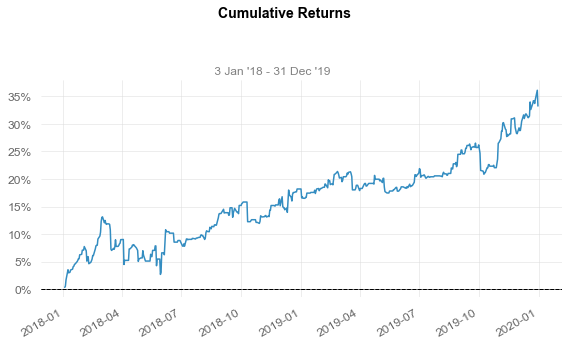

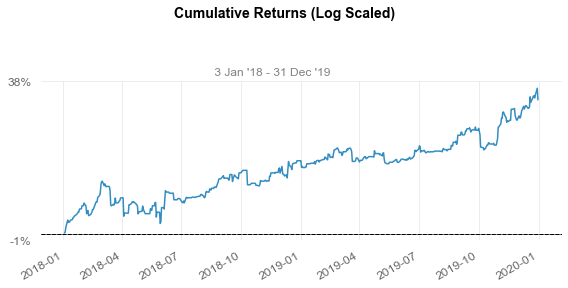

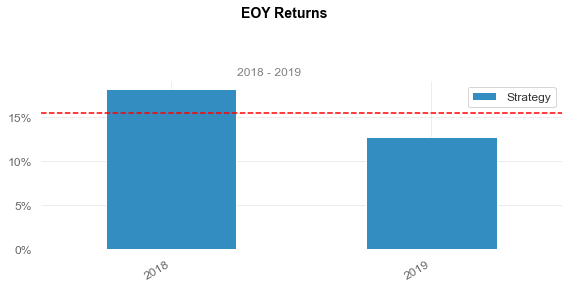

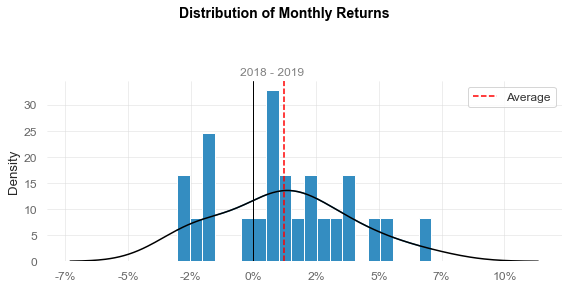

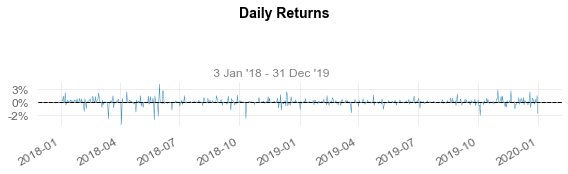

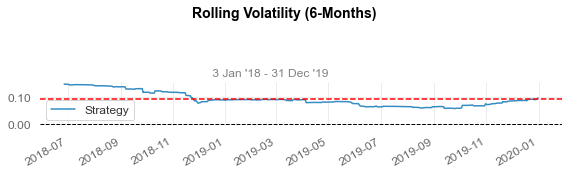

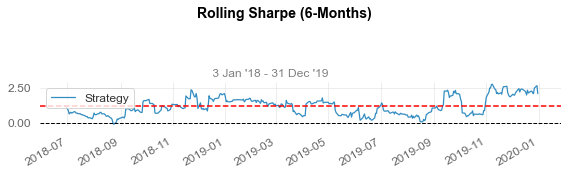

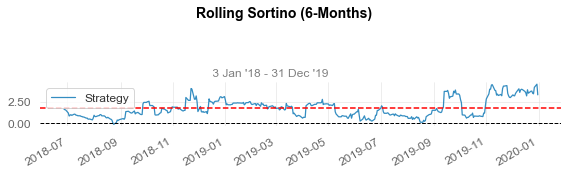

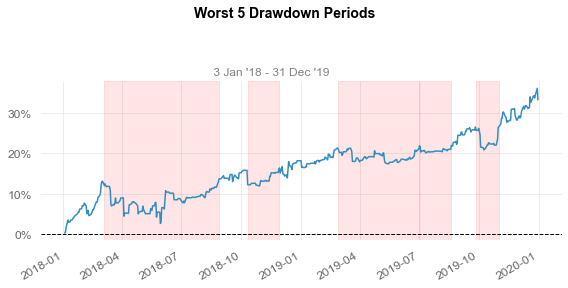

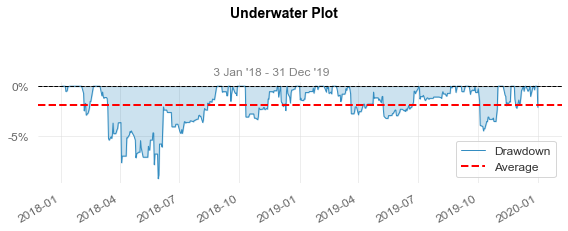

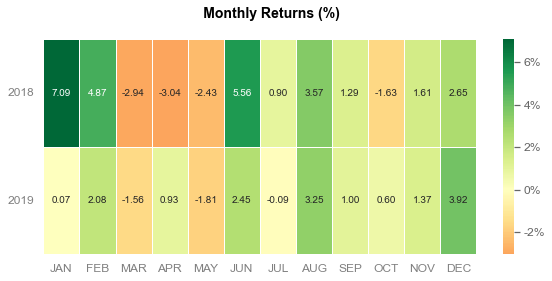

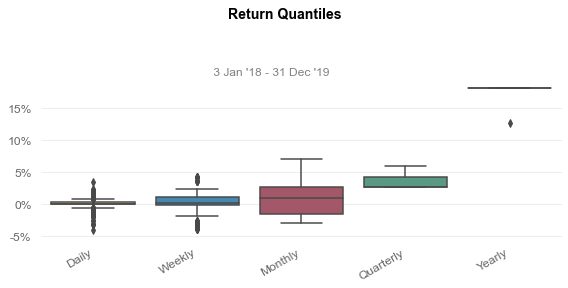

In [18]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)